# Preprocessing

## Enviroment setup and data import

In this part we will setup the environment and import the data used for this study.

In [1]:
import pandas as pd
import numpy as np

# !conda install -c conda-forge folium
# might take 15-30 minutes to resolve environment and install folium
# folimn not necessary till noticed
import folium


In [2]:
data = pd.DataFrame(pd.read_csv("taxi_data.csv"))

In [3]:
# find the headers of dataframe
list(data)

['medallion',
 'hack_license',
 'pickup_datetime',
 'dropoff_datetime',
 'trip_time_in_secs',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'total_amount']

## Data wrangling

In this part we will perform data wrangling methods. It consists of several parts.
* check for missing data problems
* find appropriate coordinates
* seperate hour, minute, second information for pickup and dropoff time
* omit unnecessary columns

In [4]:
# mising data check

print("missing data numbers: ", data.isnull().sum().sum())

missing data numbers:  0


It has been proved that there is no missing data problems in this dataset.

We have also notice a problem, that although no missing data shown in previous part, some coordinates have no realistic meanings. For example:

In [5]:
print("Numbers of dropoff longitude is 0: ", sum(data["dropoff_longitude"] == 0))
print("Numbers of dropoff latitude is 0: ", sum(data["dropoff_latitude"] == 0))

Numbers of dropoff longitude is 0:  156
Numbers of dropoff latitude is 0:  137


Therefore, we filter those taxi rides with pickup and dropoff location in a proper range.

In [6]:
# use pickup coordinates as boundaries

ny_lat_min = 40.6997
ny_lat_max = 40.8776
ny_lon_min = -74.0197
ny_lon_max = -73.9067

min_lon, max_lon, min_lat, max_lat = (ny_lon_min,
                                      ny_lon_max,
                                      ny_lat_min,
                                      ny_lat_max)

print("Minimum pickup longitude: ", min_lon)
print("Maximum pickup longitude: ", max_lon)
print("Minimum pickup latitude: ", min_lat)
print("Maximum pickup latitude: ", max_lat)

Minimum pickup longitude:  -74.0197
Maximum pickup longitude:  -73.9067
Minimum pickup latitude:  40.6997
Maximum pickup latitude:  40.8776


In [7]:
# filter the dropoff coordinates

def coordinate_filter(x, min_val, max_val):
    return min_val <= x <= max_val

data["dropoff_latitude_inrange"] = data["dropoff_latitude"].apply(
    lambda x: coordinate_filter(x, min_lat, max_lat)
)

data["dropoff_longitude_inrange"] = data["dropoff_longitude"].apply(
    lambda x: coordinate_filter(x, min_lon, max_lon)
)

data["pickup_latitude_inrange"] = data["pickup_latitude"].apply(
    lambda x: coordinate_filter(x, min_lat, max_lat)
)

data["pickup_longitude_inrange"] = data["pickup_longitude"].apply(
    lambda x: coordinate_filter(x, min_lon, max_lon)
)

In [8]:
# transform datetime to HMS, add to dataframe

datetime_obj_pickup = pd.to_datetime(data["pickup_datetime"])
data["pickup_hour"] = datetime_obj_pickup.dt.hour
data["pickup_minute"] = datetime_obj_pickup.dt.minute
data["pickup_second"] = datetime_obj_pickup.dt.second

datetime_obj_dropoff = pd.to_datetime(data["dropoff_datetime"])
data["dropoff_hour"] = datetime_obj_dropoff.dt.hour
data["dropoff_minute"] = datetime_obj_dropoff.dt.minute
data["dropoff_second"] = datetime_obj_dropoff.dt.second

In [9]:
# create psudo-timestamp variables

data["pickup_timestamp"] = (data["pickup_hour"] * 60 * 60 
                            + data["pickup_minute"] * 60
                            + data["pickup_second"])

data["dropoff_timestamp"] = (data["dropoff_hour"] * 60 * 60 
                            + data["dropoff_minute"] * 60
                            + data["dropoff_second"])

In [10]:
# select qualified rows
data_remove_row = data.loc[
    data["dropoff_latitude_inrange"] &
    data["dropoff_longitude_inrange"] &
    data["pickup_latitude_inrange"] &
    data["pickup_longitude_inrange"],
    :
]

# select necessary columns
data_final = data_remove_row.iloc[:, 4:11].join(data_remove_row.iloc[:, 15:])

In [11]:
# have a glimpse of the data
data_final = data_final.reset_index(drop = True)
data_final

,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,pickup_hour,pickup_minute,pickup_second,dropoff_hour,dropoff_minute,dropoff_second,pickup_timestamp,dropoff_timestamp
0,1801,5.0,-74.013359,40.714722,-73.972649,40.764694,23.5,18,30,59,19,1,57,66659,68517
1,172,1.0,-73.964958,40.760021,-73.971352,40.751297,7.0,19,19,7,19,22,40,69547,69760
2,260,2.0,-73.960114,40.762142,-73.974434,40.744308,8.5,2,31,6,2,34,46,9066,9286
3,521,2.0,-73.968163,40.802277,-73.984322,40.780106,9.0,12,20,6,12,29,27,44406,44967
4,1068,4.0,-73.960548,40.813354,-73.981071,40.764908,16.0,10,35,31,10,53,57,38131,39237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397994,552,2.0,-73.957405,40.722355,-73.940079,40.715858,11.4,23,59,51,0,9,3,86391,543
397995,395,2.0,-73.987450,40.757973,-74.003304,40.750622,8.0,23,59,51,0,6,26,86391,386
397996,244,1.0,-73.955299,40.714184,-73.957001,40.720531,6.0,23,59,53,0,3,57,86393,237
397997,948,2.0,-73.993874,40.742134,-73.967232,40.756779,16.2,23,59,58,0,15,46,86398,946


397,999 observations and 15 columns are chosen.

## Zone seperation and visualization

In this part we plan to seperate the data in different zones to simplify the problem. The zones would be seperated based on the following ideas.
* generally based on coordinates of the pickup and dropoff locations
* not too small which problem cannot be simplied
* not too large which creates too few cross-zone travels

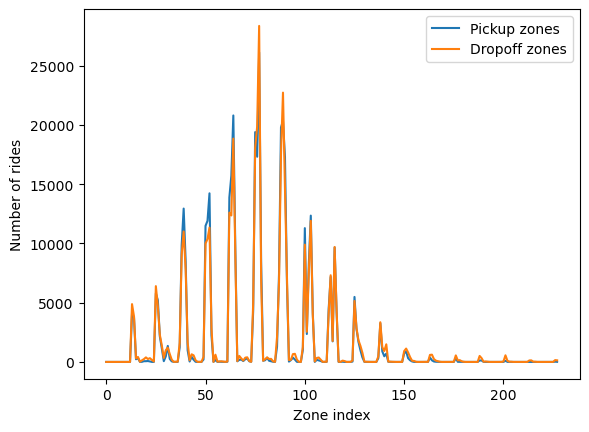

In [12]:
# a helper class to do zone seperation and add marks
from ZoneSeperation import *

# to adjust the expected zone numbers, set different parameters
zone_seperator = Zone_seperation(data_final, 200)
data_zone = zone_seperator.finilize()

In [13]:
# to access the number of rides in each zone

zone_count = pd.DataFrame({"pickup": zone_seperator.pickup_count,
                           "dropoff": zone_seperator.dropoff_count})
pd.set_option('display.max_rows', None)
zone_count

,pickup,dropoff
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


***Below part requires installation of folium***

Here's the visualization of the coordinates. As there are too many rows in the original dataset, we can only sample a few.

In [14]:
y = data_zone.sample(n = 2000)

# Manhattan coordinates
nyc_latitude = (ny_lat_min + ny_lat_max) / 2
nyc_longitude = (ny_lon_min + ny_lon_max) / 2

map_manhattan = folium.Map(location=[nyc_latitude, nyc_longitude], zoom_start=11)

# 2000 samples pickup location plot
for latitude, longitude in zip(y["pickup_latitude"], y["pickup_longitude"]):
    folium.CircleMarker(
        [latitude, longitude],
        radius = 0.5,
        color = "green",
        fill = True,
        fill_color = "green",
        fill_opacity = 0.3,
        parse_html = False).add_to(map_manhattan)
map_manhattan

In [15]:
# To find out the information for each group
# not yet finished
data_zone_select = data_zone.iloc[:, 2:6].join(data_zone.iloc[:, -2:])
pd.set_option('display.max_rows', 10)
data_zone_select

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_zone,dropoff_zone
0,-74.013359,40.714722,-73.972649,40.764694,25,89
1,-73.964958,40.760021,-73.971352,40.751297,90,77
2,-73.960114,40.762142,-73.974434,40.744308,91,65
3,-73.968163,40.802277,-73.984322,40.780106,138,112
4,-73.960548,40.813354,-73.981071,40.764908,151,88
...,...,...,...,...,...,...
397994,-73.957405,40.722355,-73.940079,40.715858,43,33
397995,-73.987450,40.757973,-74.003304,40.750622,76,74
397996,-73.955299,40.714184,-73.957001,40.720531,31,43
397997,-73.993874,40.742134,-73.967232,40.756779,63,78
